# Attention Weight Analysis: Layer Importance in Multi-Layer Probes

This notebook analyzes learned attention weights from multi-layer attentive probes to understand which vision transformer layers contribute most to downstream task performance. It either loads pre-computed attention weights from saved files or computes them from trained models if files don't exist.

The analysis extracts attention patterns from trained attentive probes that combine features from all transformer layers, revealing which intermediate representations receive the highest attention for each dataset and model combination.

**Output**: Multi-panel heatmaps showing average attention weights across layers for Small/Base/Large model variants. Each heatmap displays attention patterns for CLS and Average Pooling (AP) tokens across all transformer layers, with darker colors indicating higher attention weights. This reveals which layers are most important for different vision tasks.


In [ ]:
%load_ext autoreload
%autoreload 2
    
import sys
from pathlib import Path
import torch
import pandas as pd
sys.path.append('..')
sys.path.append('../..')
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import pickle
from functools import partial

from constants import base_model_name_mapping, BASE_PATH_PROJECT, FOLDER_SUBSTRING, experiment_with_probe_type_order_list, experiment_order_list, DS_ORDER, ds_info_file
from helper import style_multimodel_heatmap, init_plotting_params, save_or_show

from src.data.feature_combiner import TupleFeatureCombiner, StackedZeroPadFeatureCombiner
from src.data.data_loader import get_combined_feature_dl
from src.utils.utils import load_model_from_file
from src.utils.attention_utils import get_attention_weights, visualize_mean_std_attention_weights

/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-24 14:06:45.407309: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from loguru import logger
logger.remove()
logger.add(lambda message: print(message, end=""), level="WARNING")

1

In [3]:
init_plotting_params()

### UPDATE FONTSIZES FOR THIS SPECIFIC PLOT
fontsizes_cols = { 'title': 24, 'legend': 23, 'label': 23, 'ticks': 23, }

FS = fontsizes_cols

mpl.rcParams.update({
    "axes.titlesize": FS["title"],
    "axes.labelsize": FS["label"],
    "xtick.labelsize": FS["ticks"],
    "ytick.labelsize": FS["ticks"],
    "legend.fontsize": FS["legend"],
    "figure.titlesize": FS["title"],
})

{
  "agg.path.chunksize": 0,
  "axes.labelsize": 13.0,
  "axes.titlesize": 14.0,
  "axes3d.trackballsize": 0.667,
  "boxplot.flierprops.markersize": 6.0,
  "boxplot.meanprops.markersize": 6.0,
  "errorbar.capsize": 0.0,
  "figure.figsize": [
    6.4,
    4.8
  ],
  "figure.labelsize": "large",
  "figure.titlesize": "large",
  "font.cursive": [
    "Apple Chancery",
    "Textile",
    "Zapf Chancery",
    "Sand",
    "Script MT",
    "Felipa",
    "Comic Neue",
    "Comic Sans MS",
    "cursive"
  ],
  "font.family": [
    "sans-serif"
  ],
  "font.fantasy": [
    "Chicago",
    "Charcoal",
    "Impact",
    "Western",
    "xkcd script",
    "fantasy"
  ],
  "font.monospace": [
    "DejaVu Sans Mono",
    "Bitstream Vera Sans Mono",
    "Computer Modern Typewriter",
    "Andale Mono",
    "Nimbus Mono L",
    "Courier New",
    "Courier",
    "Fixed",
    "Terminal",
    "monospace"
  ],
  "font.sans-serif": [
    "DejaVu Sans",
    "Bitstream Vera Sans",
    "Computer Modern Sans Serif

**Global variables and helper functions**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

base_feature_dir = BASE_PATH_PROJECT / 'features'
base_model_dir = BASE_PATH_PROJECT / f'models_{FOLDER_SUBSTRING}_exp'

In [ ]:
storing_path_attn_weights = BASE_PATH_PROJECT / f'results_{FOLDER_SUBSTRING}_exp/aggregated'
storing_path_plots = BASE_PATH_PROJECT / f'results_{FOLDER_SUBSTRING}_exp/plots/which_layers_have_been_used_attention_heatmaps'

SAVE = "both"

if SAVE:
    storing_path_attn_weights.mkdir(parents=True, exist_ok=True)
    storing_path_plots.mkdir(parents=True, exist_ok=True)

In [6]:
# Indices where category changes occur (lengths of groups above)
category_breaks = {
    "Natural (MD)": 6,
    "Natural (SD)": 12,
    "Specialized": 15,
    "Structured": 18
}

In [7]:
palette_list = list(plt.cm.tab20c.colors)
palette_list = palette_list[4:8][::-1]
# Prepend white to the palette
palette_with_white = [(1.,1.,1.), *palette_list]
multi_color_cmap = LinearSegmentedColormap.from_list(
    "multi_gradient_with_white", 
    palette_with_white
)

In [8]:
model_name_mapping = base_model_name_mapping.copy()
model_name_mapping["Clip"] = "CLIP-B-16"
model_name_mapping["Dinov2"] = "DINOv2-B-14"
model_name_mapping["ViT-B"] = "ViT-B-16"

In [9]:
# helper: extract block number if present, otherwise put at the end
def extract_block_key(s):
    m = re.search(r'blocks\.(\d+)', s)
    return int(m.group(1)) if m else 999  # "norm" goes last

# --- Sort columns: CLS first, then AP, numeric order, 'last' at end ---
def layer_sort_key(x):
    x = str(x)
    is_cls = "cls" in x
    is_last = "last" in x
    try:
        num = int(x.split("@")[-1]) if not is_last else 999
    except ValueError:
        num = 999
    return (0 if is_cls else 1, num)

def format_layer_label(label: str) -> str:
    label = str(label)
    if label.startswith("cls@"):
        return "CLS " + ("Last" if "last" in label else label.split("@")[-1])
    elif label.startswith("ap@"):
        return "AP " + (" Last" if "last" in label else label.split("@")[-1])
    else:
        return label

def format_layer_number(label: str) -> str:
    if "last" in label:
        return "Last"
    return label.split("@")[-1]


############################# ATTENTION WEIGHTS COMPUTATION #######################################################

def get_attn_weights(model_list, save_name="total_attn_weights_large.pkl"):
    try:
        with open(storing_path_attn_weights / f"{save_name}", "rb") as f:
            total_attn_weights = pickle.load(f)
        print("Just loaded weights")
    except:        
        total_attn_weights = {}
        for base_model in model_list:
            print(f"Getting attention weights for model={base_model} ...")
            df = all_runs_large[all_runs_large["base_model"]==base_model]
            full_attn_weights = {}
            for index, row in df.iterrows():
                ds = row["dataset"].replace("/","_")
                if "imagenet" in ds:
                    continue
                print(f">> processing {ds=}")
                feature_dir = base_feature_dir / ds
                names = eval(row["model_ids"])
                # sort by group (ap/cls), then by block number
                sorted_names = sorted(names, key=lambda x: (("cls" in x), extract_block_key(x)))
                # get new sorted indices
                sorted_indices = [names.index(s) for s in sorted_names]
                
                feature_dirs = [feature_dir / mid.replace('@',"/") for mid in names]
                #print(feature_dirs)
                if np.isnan(row["dim"]):
                    print("Somehow Nan in row",row)
                    continue
                #print(int(row["dim"]))
                _, feature_test_loader = get_combined_feature_dl(
                        feature_dirs=feature_dirs,
                        batch_size = 2048,
                        num_workers=0,
                        fewshot_k=-1,
                        feature_combiner_cls=partial(StackedZeroPadFeatureCombiner, shared_dim=int(row["dim"])),
                        normalize = True,
                        load_train = False,
                    )
                model_path = base_model_dir / ds / row["model_id_n_hopt_slug"] / "model.pkl"
                model = load_model_from_file(
                    model_path = model_path, 
                    device = device
                )
                model.eval()
                test_attn_weigths = get_attention_weights(model, feature_test_loader).squeeze().mean(axis=0)[:,sorted_indices]
                full_attn_weights[ds] = (sorted_names, test_attn_weigths)
            total_attn_weights[base_model] = full_attn_weights
        with open(storing_path_attn_weights / f"{save_name}", "wb") as f:
            pickle.dump(total_attn_weights, f)
    return total_attn_weights




In [ ]:
data_info = pd.read_json(ds_info_file).T
all_runs_path_large = BASE_PATH_PROJECT / f'results_{FOLDER_SUBSTRING}_rebuttal/aggregated/complete_set_of_run.pkl'
all_runs_large = pd.read_pickle(all_runs_path_large)
all_runs_large = all_runs_large[~all_runs_large['dataset'].isin(['imagenet-subset-50k', 'wds/imagenet1k'])]
all_runs_large = all_runs_large[all_runs_large['Experiment'] == 'CLS+AP layers from all blocks (attentive)'].reset_index(drop=True)

In [ ]:
total_attn_weights = get_attn_weights(
    [ 
        'OpenCLIP_ViT-B-32_openai', 'dinov2-vit-small-p14', 'vit_small_patch16_224',
        'OpenCLIP_ViT-B-16_openai', "dinov2-vit-base-p14", 'vit_base_patch16_224',
        'OpenCLIP_ViT-L-14_openai', 'dinov2-vit-large-p14', 'vit_large_patch16_224',
    ],
     "total_attn_weights_all_models.pkl"
)

Just loaded weights


In [12]:
total_attn_weights_small = {mid:total_attn_weights[mid] for mid in ['OpenCLIP_ViT-B-32_openai', 'dinov2-vit-small-p14', 'vit_small_patch16_224']}
total_attn_weights_base  = {mid:total_attn_weights[mid] for mid in ['OpenCLIP_ViT-B-16_openai', "dinov2-vit-base-p14",'vit_base_patch16_224']}
total_attn_weights_large = {mid:total_attn_weights[mid] for mid in ['OpenCLIP_ViT-L-14_openai', 'dinov2-vit-large-p14', 'vit_large_patch16_224']}

In [13]:
all_dfs = {}
for (size, total_attn_weights) in zip(["Small","Base","Large"],[total_attn_weights_small,total_attn_weights_base,total_attn_weights_large]):
    records = []
    for model_name, model_results in total_attn_weights.items():
        for ds, (layer_names, attn) in model_results.items():
            if "imagenet" in ds:
                print("No Imagenet")
                continue
            # Mean over Heads:
            attn_mean = attn.mean(axis=0)  
            for i, lname in enumerate(layer_names):
                token_type = "CLS" if "cls" in lname else "AVG"   # split CLS vs AVG
                if "Clip" in model_name or "CLIP" in model_name:
                    layer_id = lname.split("openai_")[-1].replace("visual.transformer.resblocks.","").replace(".ln_2","").replace("visual","last")
                    #print(layer_id)
                else:
                    layer_id = lname.split("_")[-1].replace(".norm2","").replace("norm","last").replace("blocks.","")
                records.append([model_name, ds, token_type, layer_id, attn_mean[i],i])
            
    df = pd.DataFrame(records, columns=["Model","Dataset","TokenType","Layer","Attention","layer_idx"])
    all_dfs[size]=df

In [14]:
data_info = data_info.sort_values('name', key=lambda x: x.apply(lambda y: DS_ORDER.index(y) if y in DS_ORDER else np.inf))
data_info.loc['wds/vtab/diabetic_retinopathy', 'name'] = "Diab. Retinop."
data_info.loc['wds/voc2007', 'name'] = "PASCAL VOC07"

Plotting heatmap of attention weights for model sizes Small
stored image.


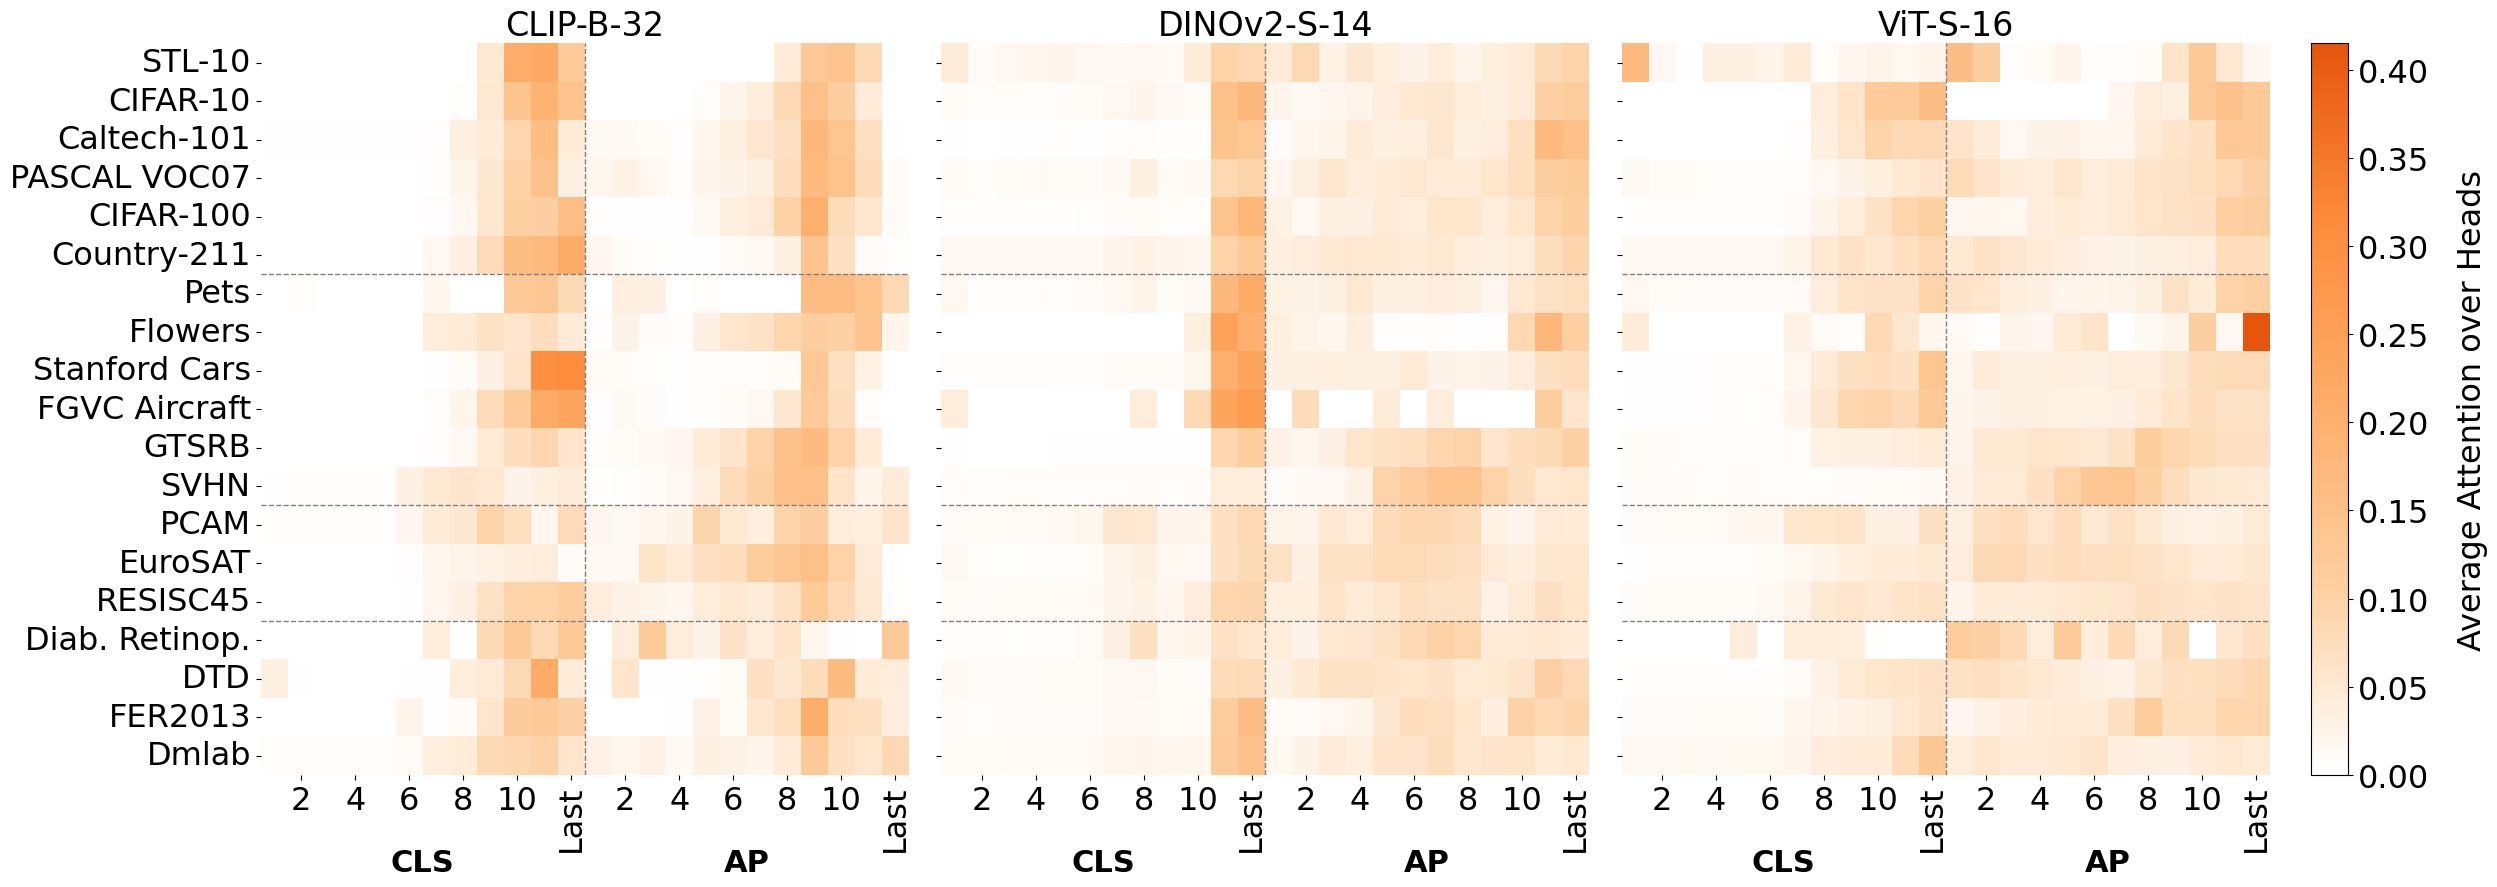


Plotting heatmap of attention weights for model sizes Base
stored image.


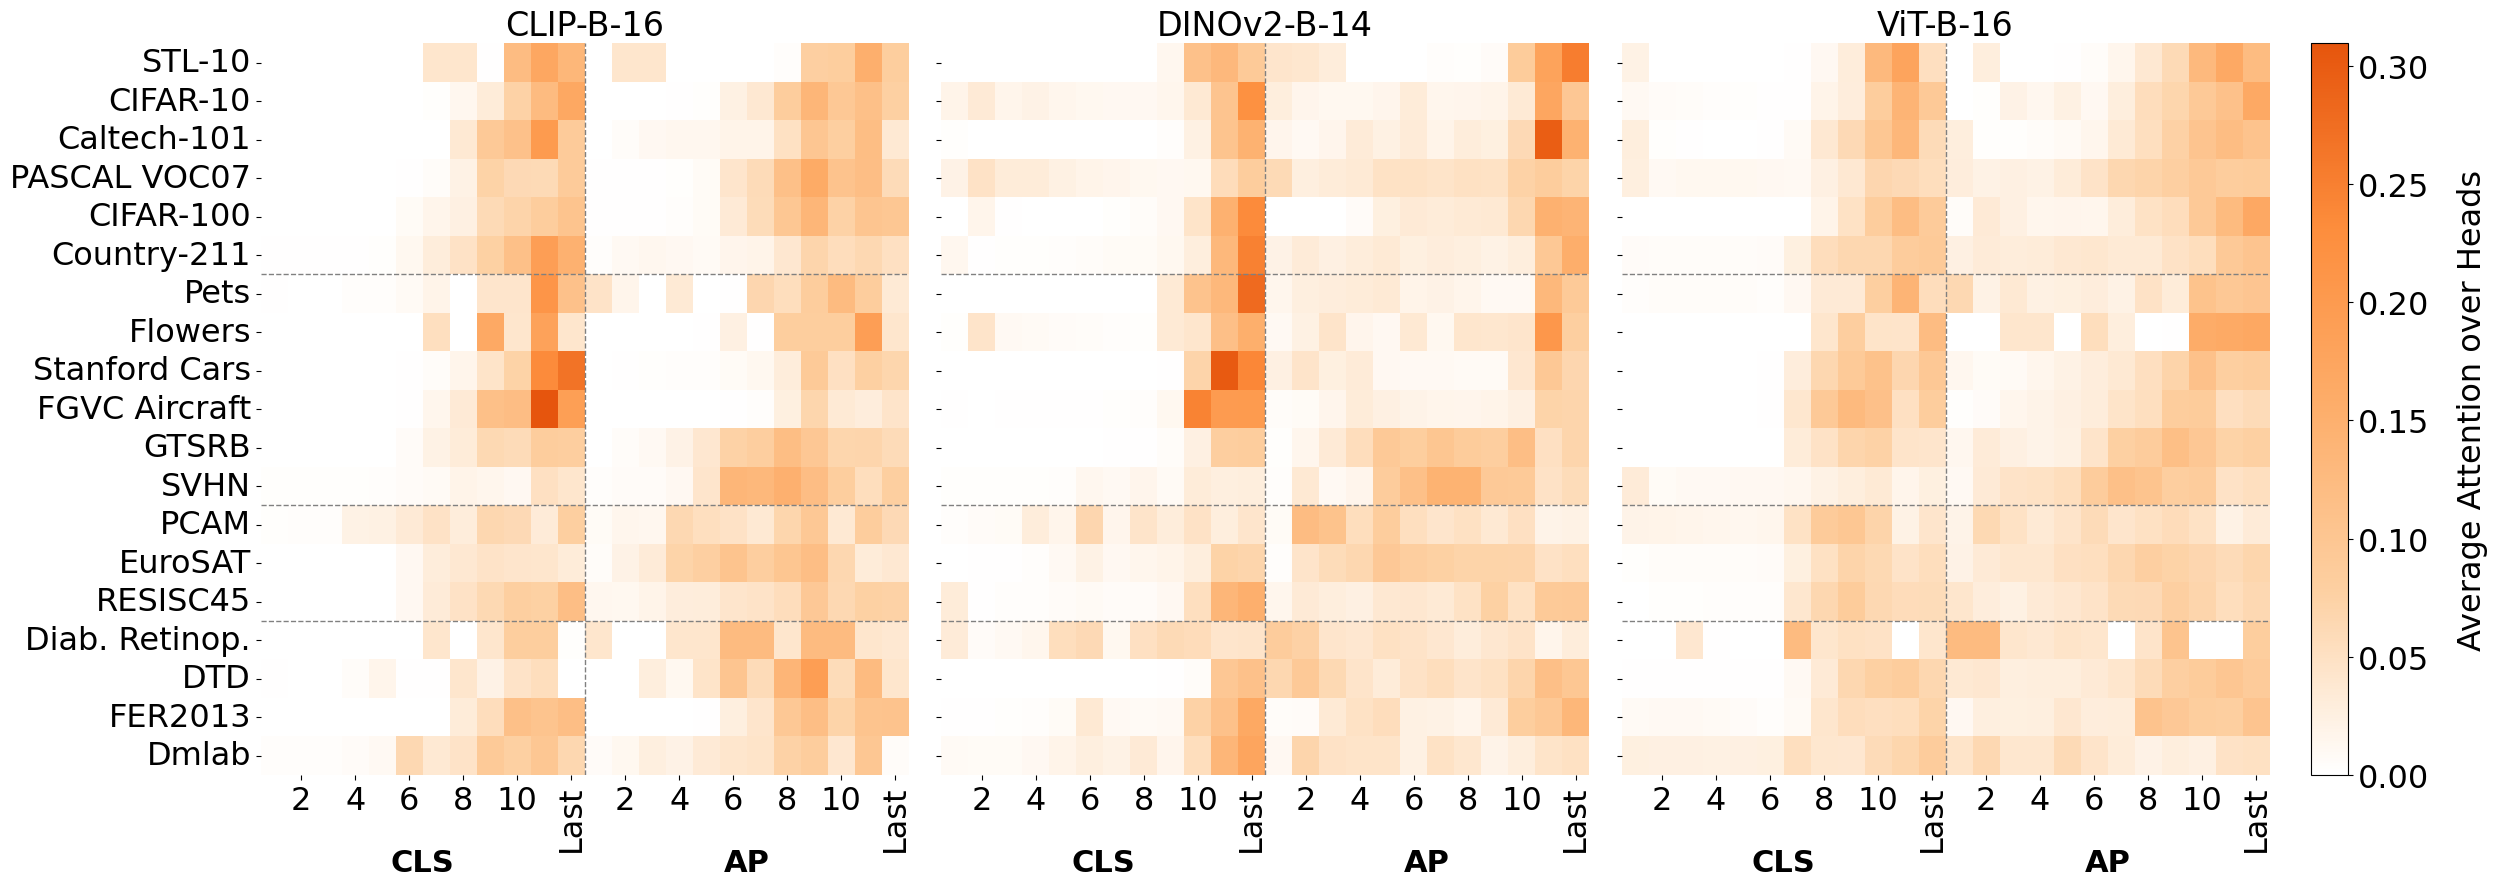


Plotting heatmap of attention weights for model sizes Large
['4', '8', '12', '16', '20', 'Last', '4', '8', '12', '16', '20', 'Last']
['4', '8', '12', '16', '20', 'Last', '4', '8', '12', '16', '20', 'Last']
['4', '8', '12', '16', '20', 'Last', '4', '8', '12', '16', '20', 'Last']
stored image.


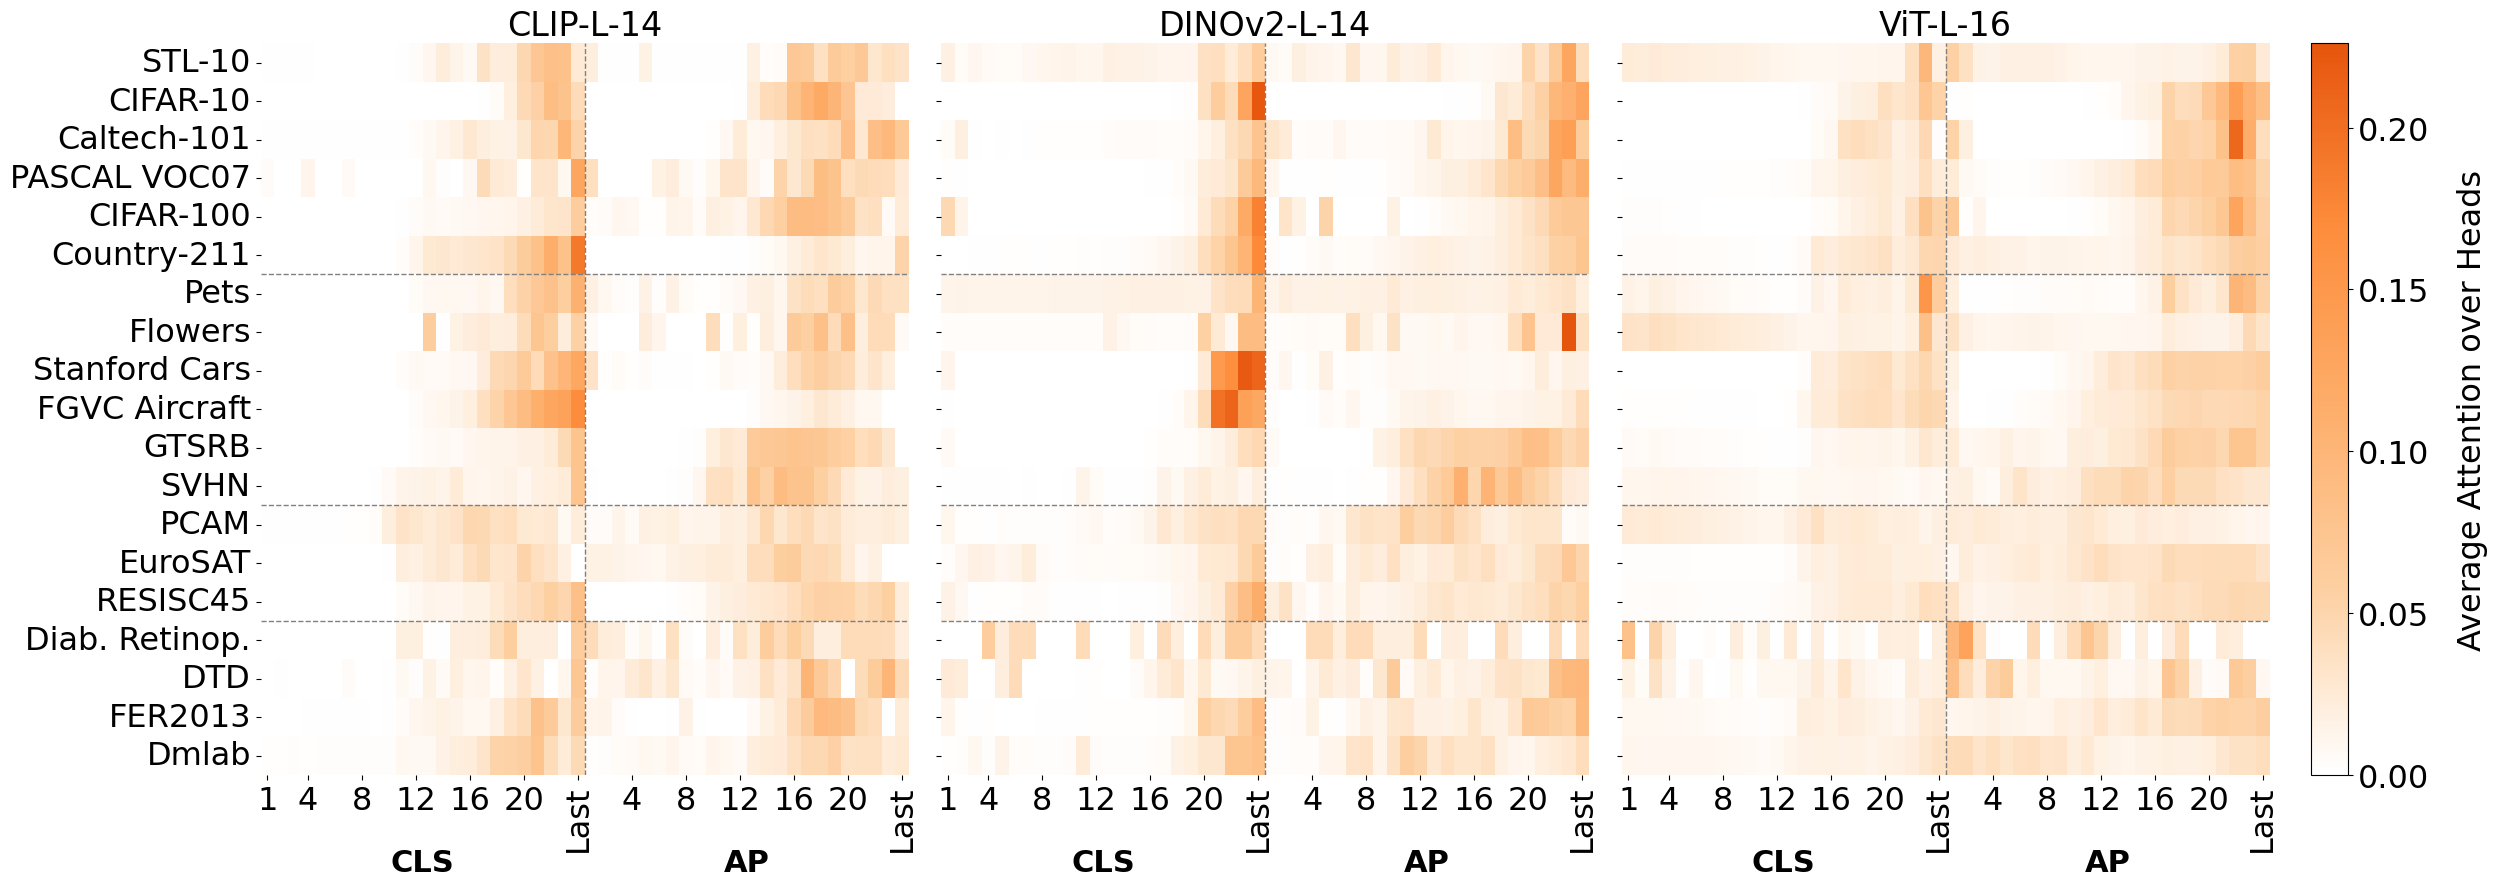

In [15]:
for size in ["Small","Base","Large"]:
    print(f"Plotting heatmap of attention weights for model sizes {size}")
    df = all_dfs[size]
    
    # --- Aggregate per Model × Dataset × Layer ---
    mean_per_dataset = (
        df.groupby(["Model","Dataset","Layer"])["Attention"]
          .mean()
          .reset_index()
    )
    
    models = df["Model"].unique()
    models = sorted(models)
    
    # --- Compute global vmin/vmax for shared colormap ---
    all_values = mean_per_dataset["Attention"].values
    vmin, vmax = all_values.min(), all_values.max()
    
    fig, axes = plt.subplots(1, len(models), figsize=(9*len(models), 9.5), sharey=True)
    fig.subplots_adjust(wspace=0.05)
    if len(models) == 1:
        axes = [axes]
    
    heatmaps = []
    for ax, model_name in zip(axes, models):
        pivot = mean_per_dataset.query("Model == @model_name").pivot(
            index="Dataset", columns="Layer", values="Attention"
        )
        pivot = pivot.rename(index=lambda ds: data_info.loc[
            ds.replace("_","/")
              .replace("fgvc/air","fgvc_air")
              .replace("diabetic/retinopathy","diabetic_retinopathy"), 
            "name"
        ])
       
        sorted_cols = sorted(pivot.columns, key=layer_sort_key)
        pivot = pivot[sorted_cols]
        pivot = pivot.reindex(data_info.iloc[0:len(DS_ORDER),:]['name'].tolist())
    
        # --- Plot heatmap ---
        hm = sns.heatmap(
            pivot, cmap=multi_color_cmap,#"viridis",
            vmin=vmin, vmax=vmax,
            cbar=False, ax=ax
        )
        heatmaps.append(hm)
    
        ax.set_title(f"{model_name_mapping[model_name]}")
        ax.set_xlabel("")
        ax.set_ylabel("")
    
        # --- Force all x-tick labels visible ---
        if len(pivot.columns) <= 24:
            ax.set_xticks(np.arange(1,len(pivot.columns),2) + 0.5)
            ax.set_xticklabels([format_layer_number(col) for col in pivot.columns][1::2], rotation=0)
        else:
            ticks_range = np.asarray([0] + list(np.arange(3,len(pivot.columns),4)))
            ax.set_xticks(ticks_range + 0.5)
            formated_col = [format_layer_number(col) for col in pivot.columns]
            print(formated_col[3::4])
            ax.set_xticklabels(formated_col[:1] + formated_col[3::4], rotation=0)
    
        ax.set_yticklabels(pivot.index)
        # Make cls@last bold
        for label in ax.get_xticklabels():
            if any(tag in label.get_text() for tag in ["Last"]):
                label.set_rotation(90)   
    
        n_cls = sum(col.startswith("cls@") for col in pivot.columns)
        n_ap = sum(col.startswith("ap@") for col in pivot.columns)
        
        # Add horizontal separator lines
        for _, row_idx in list(category_breaks.items())[:-1]:  # skip last
            ax.hlines(row_idx, *ax.get_xlim(), colors="grey",ls="--", linewidth=1)
        ax.vlines(n_cls,*ax.get_ylim(),colors="grey", ls="--",linewidth=1)
    
        
        # y position: a bit below the current x-axis labels
        ypos = -0.1
        ax.text(n_cls/2/len(pivot.columns), ypos, "CLS", ha="center", va="top", fontsize=22,fontweight="bold", transform=ax.transAxes)
        ax.text((n_cls + n_ap/2)/len(pivot.columns), ypos, "AP", ha="center", va="top", fontsize=22,fontweight="bold", transform=ax.transAxes)
    
    # --- Single shared colorbar ---
    cbar = fig.colorbar(heatmaps[-1].collections[0], ax=axes, location="right", fraction=0.02, pad=0.02)
    cbar.set_label("Average Attention over Heads", labelpad=20)


    fn =  storing_path_plots / f"AttentionWeights{size}Models.png"
    save_or_show(fig, fn, SAVE)
    print()
